In [257]:
# from langchain_openai import AzureChatOpenAI, ChatOpenAI
# from langchain_core.output_parsers import StrOutputParser

# from dotenv import load_dotenv
# import os

# load_dotenv()

# llm = AzureChatOpenAI(
#     azure_endpoint = os.environ.get("AZURE_OPENAI_ENDPOINT"),
#     openai_api_key = os.environ.get("AZURE_OPENAI_API_KEY"),
#     api_version = os.environ.get("AZURE_API_VERSION"),
#     azure_deployment = os.environ.get("AZURE_DEPLOYMENT")
# )

# # llm = ChatOpenAI(
# #     model="gpt-4o"
# #     ) 

In [258]:
# chain = (
#     llm.bind(stop=["three"])
#     | StrOutputParser()
# )

# a = chain.invoke("Repeat quoted words exactly: 'One two three four five.'")
# print(a)

In [259]:
# def multiply(a: int, b: int) -> int:
#     """Multiply a and b.

#     Args:
#         a: first int
#         b: second int
#     """
#     return a * b

# # This will be a tool
# def add(a: int, b: int) -> int:
#     """Adds a and b.

#     Args:
#         a: first int
#         b: second int
#     """
#     return a + b

# def divide(a: int, b: int) -> float:
#     """Divide a and b.

#     Args:
#         a: first int
#         b: second int
#     """
#     return a / b

# # Configuración de la conexión
# conn_str = (
#     "Driver={ODBC Driver 17 for SQL Server};"
#     "Server=tcp:<tu_servidor>.database.windows.net,1433;"
#     "Database=<tu_base_datos>;"
#     "Uid=<tu_usuario>;"
#     "Pwd=<tu_contraseña>;"
#     "Encrypt=yes;"
#     "TrustServerCertificate=no;"
#     "Connection Timeout=30;"
# )


# tools = [add, multiply, divide]
# llm_with_tools = llm.bind_tools(tools, parallel_tool_calls=False)


In [260]:
# from langgraph.graph import MessagesState
# from langchain_core.messages import HumanMessage, SystemMessage

# # System message
# sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

# # Node
# def assistant(state: MessagesState):
#    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

In [261]:
# from langgraph.graph import START, StateGraph
# from langgraph.prebuilt import tools_condition
# from langgraph.prebuilt import ToolNode
# from IPython.display import Image, display

# # Graph
# builder = StateGraph(MessagesState)

# # Define nodes: these do the work
# builder.add_node("assistant", assistant)
# builder.add_node("tools", ToolNode(tools))

# # Define edges: these determine how the control flow moves
# builder.add_edge(START, "assistant")
# builder.add_conditional_edges(
#     "assistant",
#     # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
#     # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
#     tools_condition,
# )
# builder.add_edge("tools", "assistant")
# react_graph = builder.compile()

# # Show
# display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [262]:
# messages = [HumanMessage(content="Add 3 and 4. Multiply the output by 2. Divide the output by 10")]
# messages = react_graph.invoke({"messages": messages})

In [263]:
# for m in messages['messages']:
#     m.pretty_print()

In [264]:
# import pyodbc
# from dotenv import load_dotenv
# import os

# load_dotenv()
# conn_str = (
#     "Driver={ODBC Driver 17 for SQL Server};"
#     f"Server=tcp:{os.environ.get('AZURE_SQL_ENDPOINT')},1433;"
#     f"Database={os.environ.get('AZURE_SQL_DB')};"
#     f"Uid={os.environ.get('AZURE_SQL_USER')};"
#     f"Pwd={os.environ.get('AZURE_SQL_PASS')};"
#     "Encrypt=yes;"
#     "TrustServerCertificate=no;"
#     "Connection Timeout=30;"
# )
# connection = pyodbc.connect(conn_str)
# cursor = connection.cursor()

In [265]:
# id_usuario = 1

# def fetch_data_from_sql(query):
#     cursor.execute(query, (id_usuario,))
#     rows = cursor.fetchall()
#     columns = [column[0] for column in cursor.description]
#     result = [dict(zip(columns, row)) for row in rows]
#     print(result)
#     return result

In [266]:
# query = """SELECT Nombre, Cantidad, FechaVencimiento
#             FROM [dbo].[Productos]
#             WHERE IdBoleta = (
#             SELECT TOP 1 IdBoleta
#             FROM [dbo].[Boleta]
#             WHERE IdUsuario = ? 
#             ORDER BY FechaBoleta DESC);
#         """
# productos = fetch_data_from_sql(query)

In [267]:
# query = """SELECT Detalle
#             FROM [dbo].[RecPrecedentes]
#             WHERE IdUsuario = ?;
#         """
# precedentes = [p['Detalle'] for p in fetch_data_from_sql(query)]

In [268]:
from IPython.display import Image, display
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel
import pyodbc
import os
from typing import Annotated
import operator
from pydantic import Field
from datetime import datetime

load_dotenv()
llm = ChatOpenAI(
    model="gpt-4o"
    )

In [269]:

class Prededente(BaseModel):
    tipo: str
    detalle: str

class PrecedentePerspectivas(BaseModel):
    precedentes: List[Prededente]

class Producto(BaseModel):
    producto: str
    cantidad: int
    vencimiento: str

class ProductoPerspectivas(BaseModel):
    productos: List[Producto]

class RecopilarDatosState(TypedDict):
    informacion_precedente: str
    consulta_precedente: str
    consulta_sql: Annotated[list, operator.add]
    resumen_precedente: List[Prededente]
    id: int
    edad: int
    informacion_stock: str
    consulta_stock: str
    resumen_stock: List[Producto]
    messages: str
    context: Annotated[list, operator.add]
    max_num_turns: int
    interview: str
    sections: str
    recetas: List[str]

conn_str = (
    "Driver={ODBC Driver 17 for SQL Server};"
    f"Server=tcp:{os.environ.get('AZURE_SQL_ENDPOINT')},1433;"
    f"Database={os.environ.get('AZURE_SQL_DB')};"
    f"Uid={os.environ.get('AZURE_SQL_USER')};"
    f"Pwd={os.environ.get('AZURE_SQL_PASS')};"
    "Encrypt=yes;"
    "TrustServerCertificate=no;"
    "Connection Timeout=30;"
)

In [270]:
def consulta_a_sql(state: RecopilarDatosState):
    connection = pyodbc.connect(conn_str)
    cursor = connection.cursor()
    for query in state['consulta_sql']:
        print("*"*30)
        print(query)
        print("*"*30)
        cursor.execute(query, (state['id'],))
        rows = cursor.fetchall()
        columns = [column[0] for column in cursor.description]
        result = [dict(zip(columns, row)) for row in rows]
        print("*"*30)
        print(result)
        print("*"*30)
        if '[dbo].[RecPrecedentes]' in query:
            state['informacion_precedente'] = str([p['Detalle'] for p in result])
        else:
            state['informacion_stock'] = str([f"Producto:{p['Nombre']}, Cantidad:{p['Cantidad']}, Vencimiento:{p['FechaVencimiento']}" for p in result])
    connection.close()
    return state

def traer_datos(state: RecopilarDatosState):
    state['consulta_sql'] = ["SELECT Detalle FROM [dbo].[RecPrecedentes] WHERE IdUsuario = ?;", "SELECT Nombre, Cantidad, FechaVencimiento FROM [dbo].[Productos] WHERE IdBoleta = (SELECT TOP 1 IdBoleta FROM [dbo].[Boleta] WHERE IdUsuario = ? ORDER BY FechaBoleta DESC);"]
    return consulta_a_sql(state)

In [271]:
precedentes_instrucciones="""You are tasked with understanding the following data. Follow these instructions carefully:

1. First, review all the information that will serve as an entry point. The multiple data are hosted as a elements in a Python list:
{informacion_precedente}
        
2. Group, synthesise and relate similar elements in individual paragraphs.

3. Each paragraph should have a main heading and a corresponding detail."""

def crear_resumen_precedente(state: RecopilarDatosState):   
    informacion_precedente=state['informacion_precedente']
    edad=state['edad']
    structured_llm = llm.with_structured_output(PrecedentePerspectivas)
    system_message = precedentes_instrucciones.format(informacion_precedente=informacion_precedente, edad=edad)
    precedentes = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the set of paragraphs.")])
    return {"resumen_precedente": precedentes.precedentes}

In [272]:
productos_instrucciones="""You are tasked with understanding the following data. Follow these instructions carefully:

1. First, review all the information that will serve as an entry point. The multiple data are hosted as a elements in a Python list:
{informacion_stock}
        
2. Then, synthesise the information by identifying the most likely products to expire based on expiry field, consider the corresponding quantities of each product. Group in individuals paragraphs.

3. Each paragraph should have a main with name of the product, quantity and expiry date"""

def crear_resumen_inventario(state: RecopilarDatosState):   
    informacion_stock=state['informacion_stock']
    structured_llm = llm.with_structured_output(ProductoPerspectivas)
    system_message = productos_instrucciones.format(informacion_stock=informacion_stock)
    productos = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the set of paragraphs.")])
    state["resumen_stock"] = productos.productos
    return state

In [273]:

class SearchQuery(BaseModel):
    search_query: str = Field(None)

In [274]:
question_instructions = """You are one person tasked with asking an expert about 4 to 7 healthy eating recipes for either lunch or breakfast. 

Your goal is to get the most out of the products you have available considering quantities and expiry dates. In addition, you should consider certain discomforts you have noticed in your body when you eat certain types of food. 

Here are your available products: {productos} 

Here are the discomforts you have identified: {malestares}

Start by introducing yourself by mentioning the products you have available and the discomforts you have identified, then ask the question.

Keep asking questions to go deeper and understand what types of healthy and appetising dishes you can prepare with what you have, avoiding the types of food that make you feel unwell. 

You may want to consider dishes that require additional produce. If additional items are required, indicate the quantity required for two servings for yourself. 

When you are satisfied with the alternatives, complete the interview with: "Thank you very much for your help! 

Remember to stay in character throughout your response, reflecting the person and objectives provided to you."""

def generar_pregunta(state: RecopilarDatosState):
    productos = state["resumen_stock"]
    malestares  = state["resumen_precedente"]

    system_message = question_instructions.format(productos=productos, malestares=malestares)
    question = llm.invoke([SystemMessage(content=system_message)])
    return {"messages": [question]}

In [275]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.document_loaders import WikipediaLoader

tavily_search = TavilySearchResults(max_results=3)

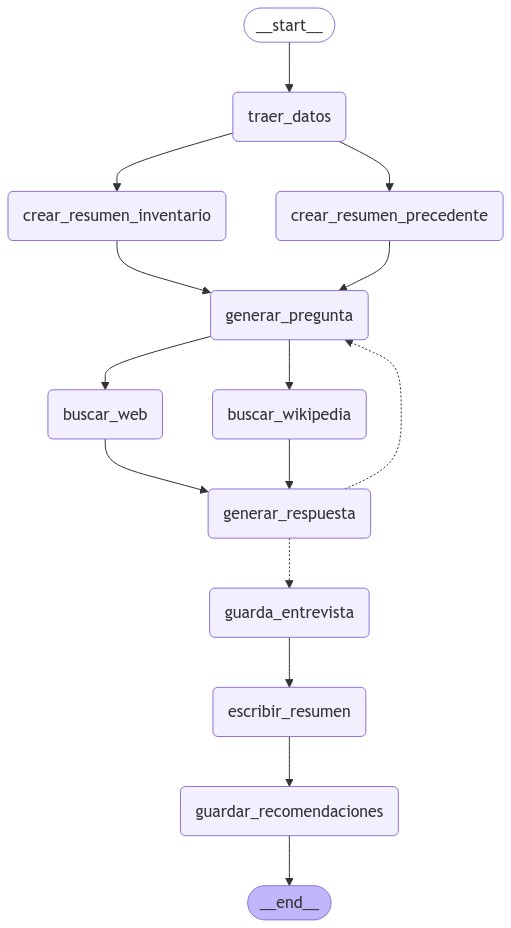

In [276]:
from langchain_core.messages import get_buffer_string

search_instructions = SystemMessage(content=f"""You will be given a conversation between an person and an expert. 

Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.
        
First, analyze the full text.

Pay particular attention to the final question posed by the analyst.

Convert this final question into a well-structured web search query""")

def buscar_web(state: RecopilarDatosState):
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    search_docs = tavily_search.invoke(search_query.search_query)
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

def buscar_wikipedia(state: RecopilarDatosState):
    structured_llm = llm.with_structured_output(SearchQuery)
    search_query = structured_llm.invoke([search_instructions]+state['messages'])
    
    search_docs = WikipediaLoader(query=search_query.search_query, 
                                  load_max_docs=2).load()

    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

answer_instructions = """You are an expert being interviewed by a person.

Here is person who has the following products to cook something some healthy dish: {resumen_stock}. 

Also, here are the ailments he reports: {resumen_precedente}
        
You goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.
      
And skip the addition of the brackets as well as the Document source preamble in your citation."""

def generar_respuesta(state: RecopilarDatosState):
    
    resumen_stock = state["resumen_stock"]
    resumen_precedente  = state["resumen_precedente"]
    messages = state["messages"]
    context = state["context"]

    system_message = answer_instructions.format(resumen_stock=resumen_stock, resumen_precedente=resumen_precedente, context=context)
    answer = llm.invoke([SystemMessage(content=system_message)]+messages)
            
    answer.name = "expert"
    
    return {"messages": [answer]}


def guarda_entrevista(state: RecopilarDatosState):
    messages = state["messages"]
    interview = get_buffer_string(messages)
    return {"interview": interview}

def enrutar_mensaje(state: RecopilarDatosState, 
                   name: str = "expert"):

    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',1)
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )
    if num_responses >= max_num_turns:
        return 'guarda_entrevista'

    last_question = messages[-2]
    
    if "Thank you so much for your help" in last_question.content:
        return 'guarda_entrevista'
    return "generar_pregunta"

system_message = """You are an expert technical writer and nutrionist. 
            
Your task is to create short paragraphs to explain and summarise each healthy recipe. 

1. Analyse the content and summarise each block of text in small paragraphs. 

2. Join all paragraphs into a single paragraph using "|" pipe delimiter. Removes any special characters or line breaks from the content.

"""

def escribir_resumen(state: RecopilarDatosState):

    context = state["messages"]
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write the required content: {context}")]) 
    return {"sections": [section.content]}

def escribir_a_sql(state: RecopilarDatosState):
    connection = pyodbc.connect(conn_str)
    cursor = connection.cursor()
    query='INSERT INTO RecAlimentarias (Detalle, FechaRecomendacion, IdUsuario) VALUES (?,?,?);'
    id = state['id']
    today = datetime.now().strftime("%Y-%m-%d")
    try:
        for receta in state['recetas']:
            cursor.execute(query, (receta, today, id,),)
            connection.commit()
        print("Data inserted successfully.")
    except Exception as e:
        print("An error occurred:", e)
    connection.close()
    return state

def guardar_recomendaciones(state: RecopilarDatosState):
    state['recetas'] = [receta.strip() for receta in state['sections'][0].split('|')]
    escribir_a_sql(state)

builder = StateGraph(RecopilarDatosState)
builder.add_node("traer_datos", traer_datos)
builder.add_node("crear_resumen_precedente", crear_resumen_precedente)
builder.add_node("crear_resumen_inventario", crear_resumen_inventario)
builder.add_node("generar_pregunta", generar_pregunta)
builder.add_node("buscar_web", buscar_web)
builder.add_node("buscar_wikipedia", buscar_wikipedia)
builder.add_node("generar_respuesta", generar_respuesta)
builder.add_node("guarda_entrevista", guarda_entrevista)
builder.add_node("escribir_resumen", escribir_resumen)
builder.add_node("guardar_recomendaciones", guardar_recomendaciones)

builder.add_edge(START, "traer_datos")
builder.add_edge("traer_datos", "crear_resumen_precedente")
builder.add_edge("traer_datos", "crear_resumen_inventario")
builder.add_edge("crear_resumen_precedente", "generar_pregunta")
builder.add_edge("crear_resumen_inventario", "generar_pregunta")
builder.add_edge("generar_pregunta", "buscar_web")
builder.add_edge("generar_pregunta", "buscar_wikipedia")
builder.add_edge("buscar_web", "generar_respuesta")
builder.add_edge("buscar_wikipedia", "generar_respuesta")
builder.add_conditional_edges("generar_respuesta", enrutar_mensaje,['generar_pregunta','guarda_entrevista'])
builder.add_edge("guarda_entrevista", "escribir_resumen")
builder.add_edge("escribir_resumen", "guardar_recomendaciones")
builder.add_edge("guardar_recomendaciones", END)

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))


In [277]:
id = 1
edad = 22
thread = {"configurable": {"thread_id": "1"}}

events = graph.stream({"id":id, "edad":edad}, thread, stream_mode="values")
for event in events:
    sections = event.get('sections', '')
    print(sections)


******************************
SELECT Detalle FROM [dbo].[RecPrecedentes] WHERE IdUsuario = ?;
******************************
******************************
[{'Detalle': 'Cuando como cosas como papas fritas de paquete o embutidos llenos de condimentos, siento un ardor intenso en el estómago, como si estuviera quemando. Es como si mi cuerpo no pudiera manejar tanto condimento y terminara causándome acidez.'}, {'Detalle': 'Cada vez que como algo bien picante, como alitas o ciertos snacks que vienen muy cargados de chile, empiezo a sudar de inmediato y siento como si mi estómago se retorciera. Incluso, a veces, me duele mucho y tengo que dejar de comer porque el malestar es demasiado.'}, {'Detalle': 'A veces, después de beber una copa de más, me empieza a dar un malestar en el estómago y siento ganas de vomitar. Al final, termino con náuseas fuertes y un dolor de cabeza horrible. Definitivamente, el alcohol en exceso me cae fatal.'}, {'Detalle': 'Me encanta el camarón, pero cada vez que 

['Tomato and Cheese Omelette is a simple and nutritious breakfast option made by beating eggs and adding chopped tomatoes and fresh cheese in a non-stick pan until set, served with orange slices. | Yogurt Parfait offers a quick and easy breakfast or snack by layering natural yogurt with orange segments and topping it with crushed corn sticks for added crunch. | Egg and Tomato Breakfast Scramble involves scrambling eggs with milk and diced tomatoes in a pan, served alongside fresh orange juice, providing a satisfying start to the day. | Tomato and Fresh Cheese Salad makes a refreshing side dish with chopped tomatoes and cheese, drizzled lightly with olive oil if available. | Fruit Salad with Orange Dressing is a simple yet delightful dish by dicing oranges and optional apples, tossed together using orange juice as a natural dressing. | Egg and Cheese Breakfast Bowl consists of cooked eggs served in a bowl with chopped tomatoes and cheese on top, offering a versatile breakfast choice. | Gluten-Free Bread Pudding is a hearty breakfast made by cubing gluten-free bread and mixing it with beaten eggs, milk, and yogurt, then baking until set, perfect for those who have gluten-free bread available.']